## Amazon Customer Review Sentiment Analysis

In [103]:
!pip install --upgrade pip
!pip install --upgrade Pillow

  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
     ---------------------------------------- 2.5/2.5 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1


In [104]:
#Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob   
import re
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
#Packages for model


#Packages for evaluation
from wordcloud import WordCloud

#Filters and display options
import warnings
warnings.filterwarnings('ignore')
warnings.warn("text too long")
pd.set_option('display.max_columns', None)
%matplotlib inline
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#Starting off by importing the csv file and reading the data
reviews = pd.read_csv('../data/amazon_reviews.csv', index_col=0)

In [32]:
#Creating a function for data frame summary statistics and viewing the data frame
def overview(df, head=5, tail=5):
   print("  TYPES   ".center(82, '-'))
   print(df.dtypes)
   
   print("  SHAPE   ".center(82,'-'))
   print(f"Rows: {df.shape[0]}")
   print(f"Columns: {df.shape[1]}")
   
   print("  DUPLICATES  ".center(82,'-'))
   print(df.duplicated().sum())
   
   print("  NaN VALUES".center(82,'-'))
   print(df.isna().sum())
   
   print("  QUANTILES   ".center(82,'-'))
   print(df.quantile([0,0.05,0.50,0.95,0.99,1]).T)
   
   print("  DATAFRAME PREVIEW   ".center(82, '-'))
   print(df.head(n=5))
   print(df.tail(n=5))

In [42]:
#Calling the function
overview(reviews)

------------------------------------  TYPES   ------------------------------------
reviewerName             object
overall                  object
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
------------------------------------  SHAPE   ------------------------------------
Rows: 4914
Columns: 11
----------------------------------  DUPLICATES  ----------------------------------
0
-----------------------------------  NaN VALUES-----------------------------------
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_boun

Based on the overview function call, we can see that most of the data frame columns are either int or float types. I can also see that there are 4915 rows spanning across 12 columns of data. As for null values there appear to only be 2, so there won't be much cleaning up to do of null values in this data set at first glance. I'm also viewing the first 5 and last 5 rows of the data frame to get a general understanding of what's contained in the data. Based on the nature of the data, it looks like the 'overall' column can be used as the target variable. The float type will be replaced with string values, 0-2 will be seen as negative, 3 will be neutral and 4-5 will be positive.

## Step 1:
Remove any NaN values

In [39]:
#Taking a look at the NaN value before replacing it 
reviews['reviewerName'].head()

0      randomName
1            0mie
2             1K3
3             1m2
4    2&amp;1/2Men
Name: reviewerName, dtype: object

Since the only NaN value in this column is a customer name, we will assign a random name to the customer. This step is be taken since the reviewernames have no affect on our dataset. 

In [38]:
reviews['reviewerName'].fillna('randomName', inplace=True)

Next up is the reviewText column, since the contents of this column are going to be used later to perform sentiment analysis, any NaN values here will have to be dropped instead of replaced. To do this, I'm going to drop the entire row that contains the NaN value. 

In [41]:
reviews.dropna(inplace=True)

## Step 2:
Convert the float column 'overall' to sentiment string values 

In [7]:
#Creating a simple function to return sentiment type
def sentimentType(score):
    if score == 4.0 or score == 5.0:
        return 'Positive'
    elif score == 3.0:
        return 'Neutral'
    elif score == 1.0 or score == 2.0:
        return 'Negative'

In [8]:
#Applying the function created earlier to the overall column
reviews['overall'] = reviews['overall'].apply(sentimentType)
reviews.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,NaN,Positive,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,0mie,Positive,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,1K3,Positive,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,1m2,Positive,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,2&amp;1/2Men,Positive,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


Text(0.5, 0, 'Sentiment Type')

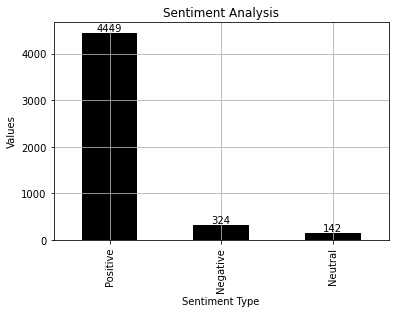

In [23]:
#Visualizing the data after converting overall column to string values 
ax = reviews['overall'].value_counts().plot(kind='bar', grid=True, colormap='gray')
ax.bar_label(ax.containers[0])
plt.title('Sentiment Analysis')
plt.ylabel('Values')
plt.xlabel('Sentiment Type')

## Step 3:
Explore the reviewText column and convert to string type/lower case 

In [47]:
#Converting the values in reviewText to string values and changing the case to lower
reviews['reviewText'] = reviews['reviewText'].astype(str).apply(lambda text: text.lower())

Next, a function will be created to remove URLs, special characters, mentions and any non-alphanumeric characters from the reviews. The text will also be converted to lowercase and tokenized. Stopwords will be removed and stemmming will be performed - words will be converted to their base or root form. This will ensure that words aren't double counted. 

In [62]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def text_processing(text):
    text = re.sub(r"https?\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text_tokens = word_tokenize(text.lower())
    filtered_text = [i for i in text_tokens if i not in stop_words]
    stem_wrods = [stemmer.stem(w) for w in filtered_text]
    return " ".join(stem_wrods)

In [63]:
#Applying the function to the review dataset for preprocessing 
reviews["reviewText"] = reviews['reviewText'].apply(text_processing)

In [64]:
#Saving the first few lines of reviews to a sample dataframe for review
sample_reviews = reviews['reviewText'].head(10)

In [65]:
#Dropping all duplicates values in each comment
reviews = reviews.drop_duplicates('reviewText')

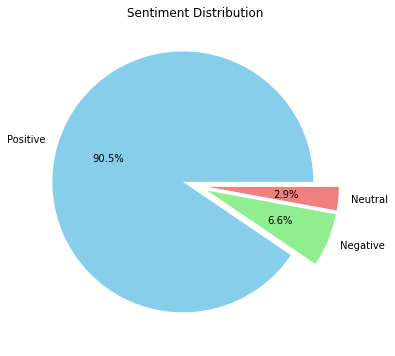

In [72]:
sentiment_counts = reviews['overall'].value_counts(normalize=True) * 100
colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'pink']
explode = (0.1, 0.1, 0.1)
#Plotting the pie chart
plt.figure(figsize=(8,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('Sentiment Distribution')
plt.show()

Based on the pie chart we can see that about 90.5% of reviews for this product were positive, 6.6% were negative and 2.9% neutral. Based on those numbers, we know two things:
1. This product looks to be a succesful product for the business based on reviews, but the revenue attributed to the product would have to be investigated before making a confident decision on the product.
2. We should perform outreach to 9.5% of the customers that reviewed this product, that is a sum of both the neutral and negative reviews. We should reach out to the negative comments to understand what was there experience and how could we make improvements. For the neutral reviews we should also be reaching out to understand what they liked about the product and what was missing from the product that stopped them from truly loving it. 

## Step 4:
Creating a visual representation of the most common words found in each of the three categories:
1. Positive
2. Neutral
3. Negative

In [131]:
font_path = "C:/Windows/Fonts/arial.ttf"

#Defining a function to count and visualize the number 
def frequent_words(comments):
    text = ' '.join([word for word in comments['reviewText']])
    plt.figure(figsize = (15,15), facecolor='None')
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most frequent words in {comments}', fontsize=19)
    plt.show()

In [129]:
#Creating variables to isolate the positive, neutral and negative comments
positive_comments = reviews[reviews['overall'] == 'Positive']
neutral_comments = reviews[reviews['overall'] == 'Neutral'] 
negative_comments = reviews[reviews['overall'] == 'Negative']  

In [132]:
frequent_words(positive_comments)

ValueError: Only supported for TrueType fonts

<Figure size 1080x1080 with 0 Axes>

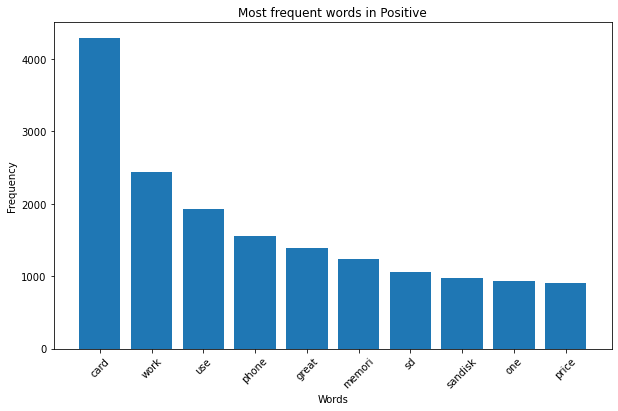

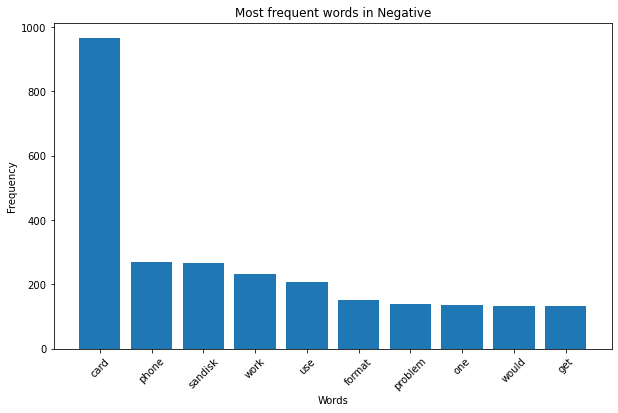

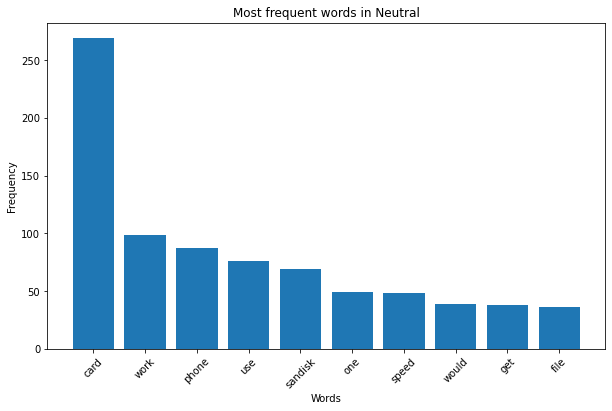

In [113]:
# Import the necessary libraries
from collections import Counter

# Define a function to count and visualize the most frequent words
def frequent_words(comments, category):
    text = ' '.join([word for word in comments['reviewText']])
    word_tokens = text.split()
    word_counter = Counter(word_tokens)
    most_common = word_counter.most_common(10)  # Get the top 10 most frequent words

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    words, counts = zip(*most_common)
    plt.bar(words, counts)
    plt.title(f'Most frequent words in {category}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Call the function for each category
frequent_words(positive_comments, 'Positive')
frequent_words(negative_comments, 'Negative')
frequent_words(neutral_comments, 'Neutral')

In [125]:
from wordcloud import WordCloud


font_path = "C:/Windows/Fonts/Arial.ttf"
def frequent_words(comments, category):
    text = ' '.join([word for word in comments['reviewText']])
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most frequent words in {category}')
    plt.axis('off')
    plt.show()

# Call the function for each category
frequent_words(positive_comments, 'Positive')
frequent_words(negative_comments, 'Negative')
frequent_words(neutral_comments, 'Neutral')

ValueError: Only supported for TrueType fonts